2025-04-07 14:40:39.337096: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 14:40:39.365966: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-07 14:40:40.057692: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Training data shape: (22992, 60, 17)
Validation data shape: (2874, 60, 17)
Testing data shape: (2874, 60, 17)


W0000 00:00:1744026040.694041   27754 gpu_device.cc:2340] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/jesse/Projects/myenvs/tf_nightly/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,953 (132.63 KB)

 Trainable params: 33,953 (132.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0033 - val_loss: 1.3175e-04
Epoch 2/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 6.3024e-05 - val_loss: 4.8384e-05
Epoch 3/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 4.7179e-05 - val_loss: 5.6247e-05
Epoch 4/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 5.2541e-05 - val_loss: 3.1051e-05
Epoch 5/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 4.3959e-05 - val_loss: 9.9278e-05
Epoch 6/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 3.5194e-05 - val_loss: 2.5270e-05
Epoch 7/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 3.1190e-05 - val_loss: 5.7090e-05
Epoch 8/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 3.0843e-05 - val_loss: 5.3658e-05
Epoch 9/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 2.7343e-05 - val_loss: 4.6102e-05
Epoch 10/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 2.8182e-05 - val_loss: 1.9450e-05
Epoch 11/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/ste

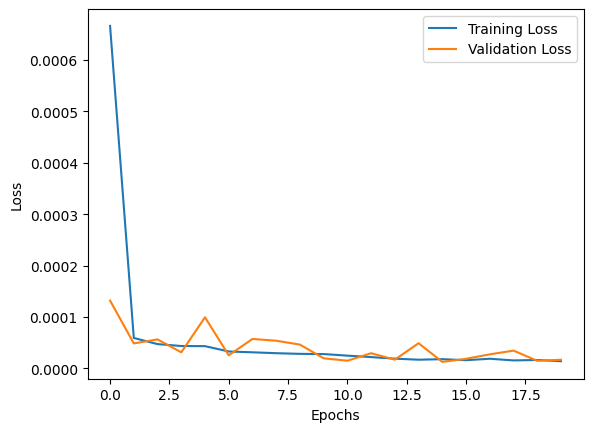

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2284e-05
Test Loss: 0.00016760407015681267
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


ValueError: non-broadcastable output operand with shape (2874,1) doesn't match the broadcast shape (2874,17)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Load the combined dataframe
combined_df = pd.read_csv('Training/Combined_Data.csv', parse_dates=["Date"])

# Sort by Date to ensure correct ordering
combined_df.sort_values(by=["Date", "Ticker"], inplace=True)

# Encode Ticker column (if you want to keep it as a feature)
label_encoder = LabelEncoder()
combined_df['Ticker'] = label_encoder.fit_transform(combined_df['Ticker'])

# Drop 'Date' column and '5_day_return' (target) column for scaling
features = combined_df.drop(columns=['Date', '5_day_return'])

# Normalize the features (MinMax scaling to [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Create sequences for LSTM (60 days window)
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])  # Input: previous 60 days
        y.append(data[i, -1])  # Output: 5-day return (last column)
    return np.array(X), np.array(y)

# Apply function to create sequences for all stocks
X, y = create_sequences(scaled_features)

# Split the data into train, validation, and test sets (80%, 10%, 10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Testing data shape: {X_test.shape}")

# Build the LSTM model
model = tf.keras.Sequential()

# Add LSTM layers
model.add(tf.keras.layers.LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.LSTM(units=32))
model.add(tf.keras.layers.Dense(16, activation='relu'))  # Fully connected layer
model.add(tf.keras.layers.Dense(1))  # Output layer (predicts the 5-day return)

# Compile the model with mixed precision
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Plot the training and validation loss (optional)
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Predict on the test data
y_pred = model.predict(X_test)

# Rescale the predictions if needed (inverse the scaling)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Print the predicted vs true values (for comparison)
print(f"Predicted 5-day return: {y_pred_rescaled[:5]}")
print(f"True 5-day return: {y_test_rescaled[:5]}")
